# GFS embedding network

In [1]:
import os
import sys
import time
import math
import numpy as np
from glob import glob

import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR) 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

## Hyperparameters

In [21]:
filter_nums = [64, 128, 256] # number of convolution kernels per down-/upsampling layer 

# activation function
activation = 'relu'
activation_fn = keras.activations.relu

# GFS input sizes
input_size = (128, 128, 8)

# Embedded GFS sizes
latent_size = (16, 16, filter_nums[-1])

load_weights = True
# location of the previous weights
model_name_load = '/glade/work/ksha/GAN/models/BC_{}_{}_{}_tune'.format(filter_nums[0], filter_nums[1], activation)
# location for saving new weights
model_name_save = '/glade/work/ksha/GAN/models/BC_{}_{}_{}_tune'.format(filter_nums[0], filter_nums[1], activation)

lr = 1e-5 # learning rate

# samples per epoch = N_batch * batch_size
epochs = 99999
N_batch = 64
batch_size = 32

## Model design

In [22]:
# print('tf.version = {}'.format(tf.__version__))
# print('tf on GPU = {}'.format(tf.test.is_gpu_available()))

In [23]:
# ---------------- encoder ----------------- #
# forecast lead time embeddings
time_input = keras.Input(shape=(), dtype=tf.int64)
temb = mu.TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = mu.TimeMLP(units=filter_nums[0]*4, activation_fn=activation_fn)(temb)

encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])

X = layers.Conv2D(filter_nums[2], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])

encoder_out = X

model_encoder = keras.Model([encoder_in, time_input], encoder_out)

# ---------------- decoder ----------------- #
decoder_in = keras.Input(shape=latent_size)

# forecast lead time embeddings
time_input = keras.Input(shape=(), dtype=tf.int64)
temb = mu.TimeEmbedding(dim=filter_nums[0]*4)(time_input)
temb = mu.TimeMLP(units=filter_nums[0]*4, activation_fn=activation_fn)(temb)

X = decoder_in

X = layers.Conv2DTranspose(filter_nums[2], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[2], activation_fn=activation_fn)([X, temb])

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[1], activation_fn=activation_fn)([X, temb])

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])
X = mu.ResidualBlock_base(filter_nums[0], activation_fn=activation_fn)([X, temb])

decoder_out = layers.Conv2D(1, 1, padding="same")(X)

model_decoder = keras.Model([decoder_in, time_input], decoder_out)

# ---------------- combined ----------------- #
# forecast lead time input
time_input = keras.Input(shape=(), dtype=tf.int64)
# GFS inputs
IN = keras.Input(shape=input_size)
# the mdoel
X_encode = model_encoder([IN, time_input])
OUT = model_decoder([X_encode, time_input])
model = keras.Model([IN, time_input], OUT)
# compile
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=lr))

# load weights
if load_weights:
    W_old = mu.dummy_loader(model_name_load)
    model.set_weights(W_old)

## Validation set preparation

In [24]:
# location of training data
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/'

# validation set size
L_valid = 100

# collect validation set sampales
filenames = np.array(sorted(glob(BATCH_dir+'*.npy')))
L = len(filenames)

filename_valid = filenames[:L_valid]
filename_train = list(set(filenames) - set(filename_valid))
L_train = len(filename_train)

Y_valid = np.empty((L_valid, 128, 128, 1))
X_valid = np.empty((L_valid, 128, 128, 8))
T_valid = np.empty((L_valid,))

for i, name in enumerate(filename_valid):
    temp_data = np.load(name)
    Y_valid[i, ..., 0] = temp_data[0, ..., 0]
    X_valid[i, ...] = temp_data[0, ..., 1:]
    T_valid[i] = int(name[-25:-23])

In [25]:
# get lead time information for batch filename
print(name[-25:-23])

03


## Model training

In [33]:
# collect training samples
filenames = np.array(sorted(glob(BATCH_dir+'*.npy')))
L = len(filenames)
filename_valid = filenames[:L_valid]
filename_train = list(set(filenames) - set(filename_valid))
L_train = len(filename_train)

min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

Y_batch = np.empty((batch_size, 128, 128, 1)); Y_batch[...] = np.nan
X_batch = np.empty((batch_size, 128, 128, 8)); X_batch[...] = np.nan
T_batch = np.empty((batch_size,)); T_batch[...] = np.nan

for i in range(epochs):
    
    # model training with on-the-fly batch generation
    # # -------------------------------------
    # L_valid = 100
    # filenames = np.array(sorted(glob(BATCH_dir+'*.npy')))
    # L = len(filenames)
    # filename_valid = filenames[:L_valid]
    # filename_train = list(set(filenames) - set(filename_valid))
    # L_train = len(filename_train)
    # # -------------------------------------
    
    print('epoch = {}'.format(i))
    if i == 0:
        Y_pred = model.predict([X_valid, T_valid])
        record = du.mean_absolute_error(Y_valid, Y_pred)
        print('Initial validation loss: {}'.format(record))
    
    start_time = time.time()
    for j in range(N_batch):
        inds_rnd = du.shuffle_ind(L_train)
        inds_ = inds_rnd[:batch_size]

        for k, ind in enumerate(inds_):
            # import batch data
            name = filename_train[ind]
            temp_data = np.load(name)
            Y_batch[k, ..., 0] = temp_data[0, ..., 0]
            X_batch[k, ...] = temp_data[0, ..., 1:]
            T_batch[k] = int(name[-25:-23])
            
        model.train_on_batch([X_batch, T_batch], Y_batch)
        
    # on epoch-end
    Y_pred = model.predict([X_valid, T_valid])
    record_temp = du.mean_absolute_error(Y_valid, Y_pred)

    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        model.save(model_name_save)
        
    else:
        print('Validation loss {} NOT improved'.format(record_temp))

    print("--- %s seconds ---" % (time.time() - start_time))
    # mannual callbacks

## Show examples

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
Y_pred = model.predict([X_valid, T_valid])
#print(np.mean(np.abs((np.exp(Y_valid[..., 0])-1))))
print(np.mean(np.abs((np.exp(Y_valid[..., 0])-1) - (np.exp(X_valid[..., 0])-1))))
print(du.mean_absolute_error(np.exp(Y_valid)-1, np.exp(Y_pred)-1))

4/4 [==============================] - 0s 48ms/step
1.3611985003662104
1.1102490961063112
0.9021887763280085


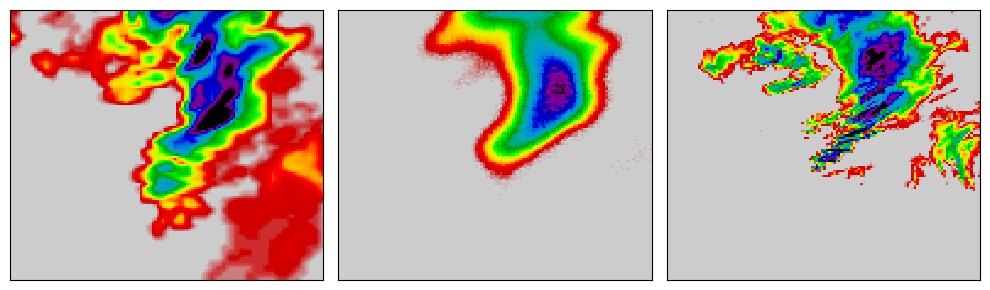

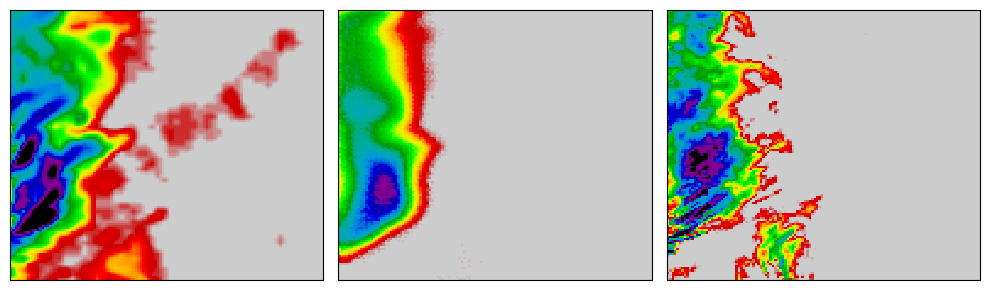

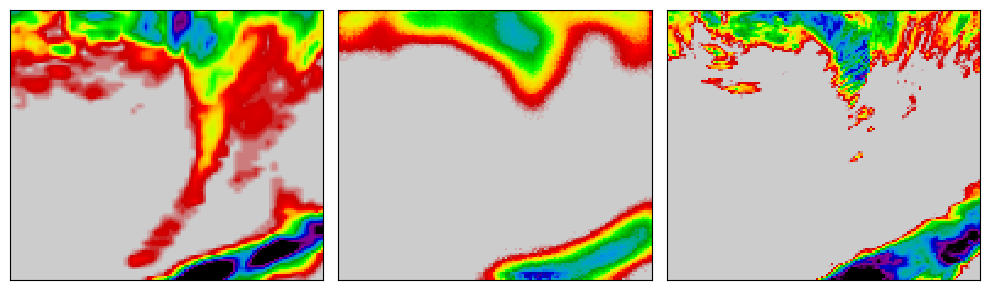

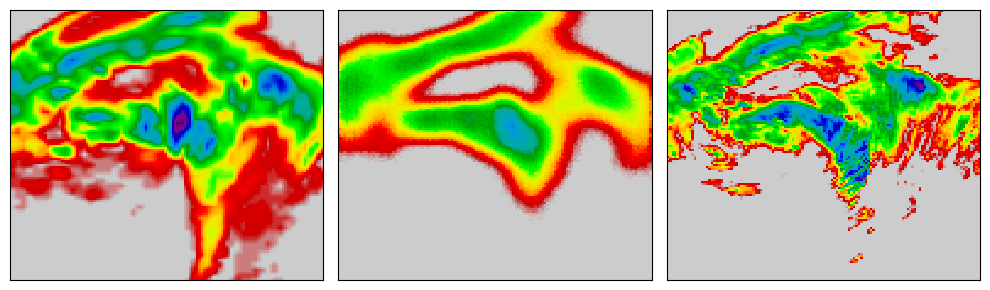

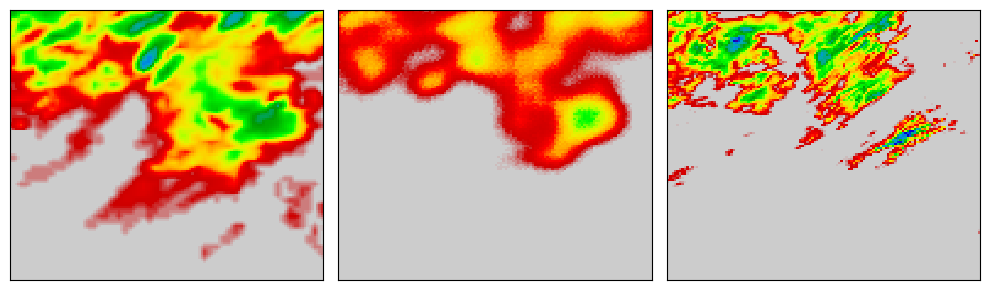

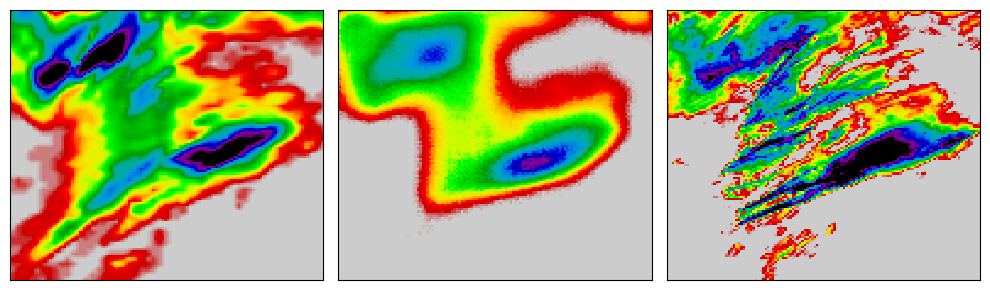

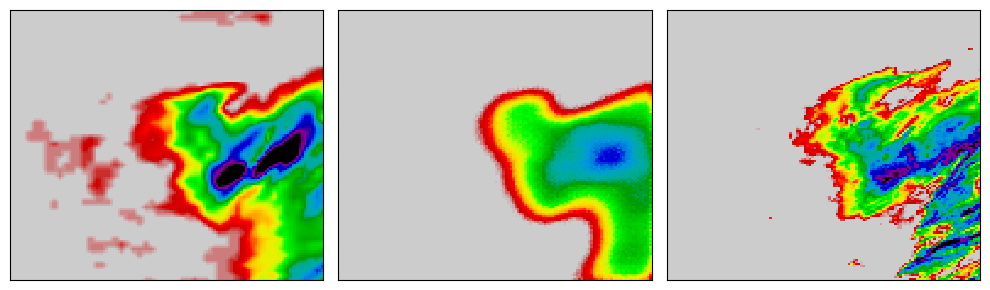

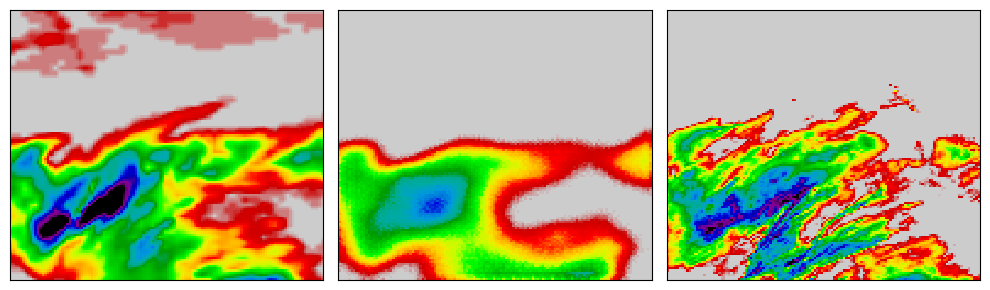

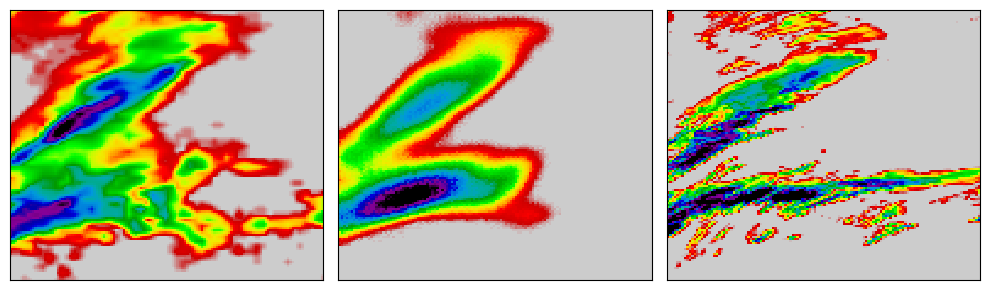

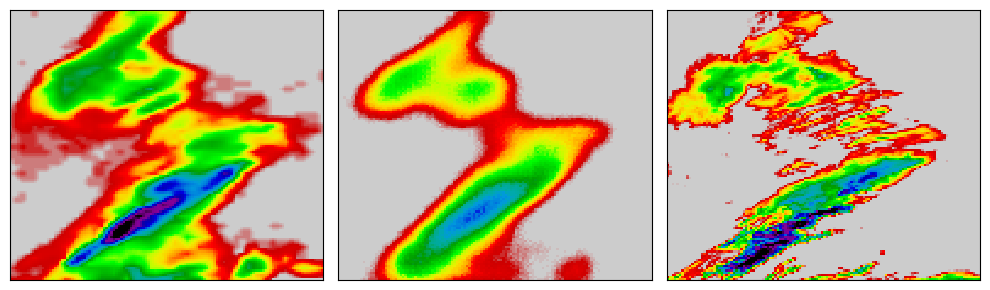

In [31]:
for i in range(0, L_valid, 10):

    fig, AX = plt.subplots(1, 3, figsize=(10, 3))
    
    for ax in AX:
        ax.tick_params(axis="both", which="both", bottom=False, 
                       top=False, labelbottom=False, left=False,
                       right=False, labelleft=False)
    plt.tight_layout()
    
    AX[0].pcolormesh(X_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[1].pcolormesh(Y_pred[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[2].pcolormesh(Y_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)